In [43]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Animals/animal_dataset"
classes = ["cat", "dog", "panda"]
print("Dataset Path:", dataset_path)
print("Classes:", classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Path: /content/drive/MyDrive/Animals/animal_dataset
Classes: ['cat', 'dog', 'panda']


In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter
import random


In [45]:
def load_dataset(dataset_path, classes):
    X, y = [], []
    for label, cls in enumerate(classes):
        folder = os.path.join(dataset_path, cls)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (32, 32))
            X.append(img.flatten())
            y.append(label)
    return np.array(X), np.array(y)
X, y = load_dataset(dataset_path, classes)
print("Total images loaded:", len(X))


Total images loaded: 300


In [46]:
def L1(a, b):
    return np.sum(np.abs(a - b))

def L2(a, b):
    return np.sqrt(np.sum((a - b)**2))


In [47]:
def knn_predict(train_X, train_y, test_sample, K, dist_type="L2"):
    distances = []
    for i in range(len(train_X)):
        d = L1(test_sample, train_X[i]) if dist_type=="L1" else L2(test_sample, train_X[i])
        distances.append((d, train_y[i], i))
    distances.sort(key=lambda x: x[0])
    top_labels = [label for _, label, _ in distances[:K]]
    return Counter(top_labels).most_common(1)[0][0]


In [48]:
def evaluate_knn(X, y, K_values):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    acc_L1, acc_L2 = [], []

    for K in K_values:
        fold_acc_L1, fold_acc_L2 = [], []
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # L1
            correct = 0
            for i in range(len(X_test)):
                pred = knn_predict(X_train, y_train, X_test[i], K, "L1")
                if pred == y_test[i]:
                    correct += 1
            fold_acc_L1.append(correct / len(X_test))

            # L2
            correct = 0
            for i in range(len(X_test)):
                pred = knn_predict(X_train, y_train, X_test[i], K, "L2")
                if pred == y_test[i]:
                    correct += 1
            fold_acc_L2.append(correct / len(X_test))
        acc_L1.append(np.mean(fold_acc_L1))
        acc_L2.append(np.mean(fold_acc_L2))

    return acc_L1, acc_L2


L1 Accuracies: [np.float64(0.42666666666666664), np.float64(0.41999999999999993), np.float64(0.45), np.float64(0.4366666666666667), np.float64(0.43)]
L2 Accuracies: [np.float64(0.4033333333333333), np.float64(0.41), np.float64(0.4133333333333334), np.float64(0.4633333333333334), np.float64(0.44333333333333336)]


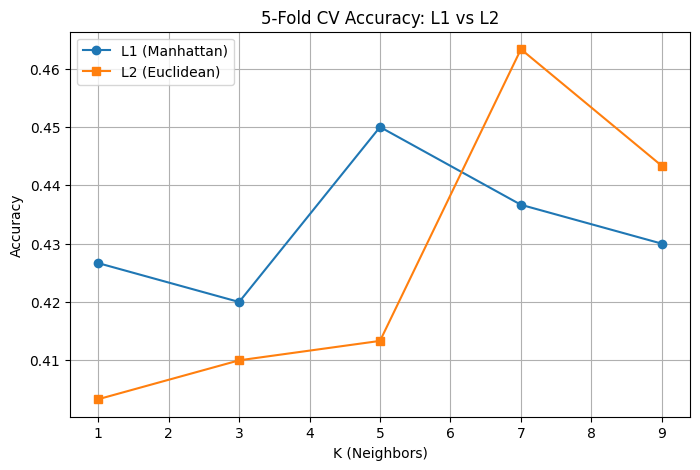

In [49]:
K_values = [1, 3, 5, 7, 9]
acc_L1, acc_L2 = evaluate_knn(X, y, K_values)

print("L1 Accuracies:", acc_L1)
print("L2 Accuracies:", acc_L2)

# Plot
plt.figure(figsize=(8,5))
plt.plot(K_values, acc_L1, marker='o', label="L1 (Manhattan)")
plt.plot(K_values, acc_L2, marker='s', label="L2 (Euclidean)")
plt.xlabel("K (Neighbors)")
plt.ylabel("Accuracy")
plt.title("5-Fold CV Accuracy: L1 vs L2")
plt.grid(True)
plt.legend()
plt.show()


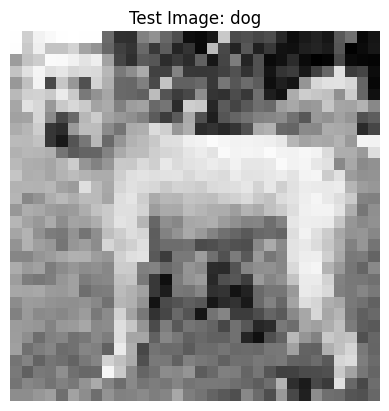

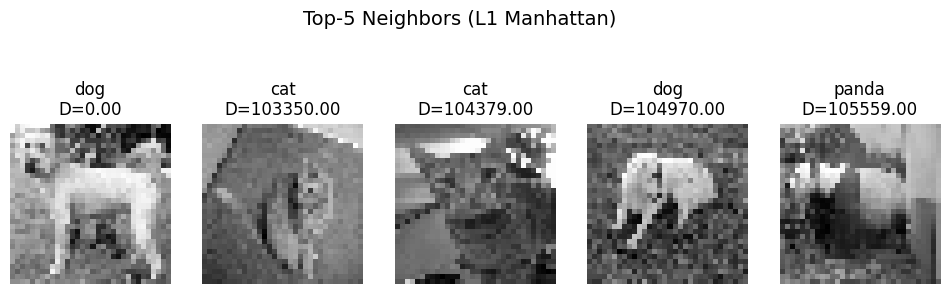

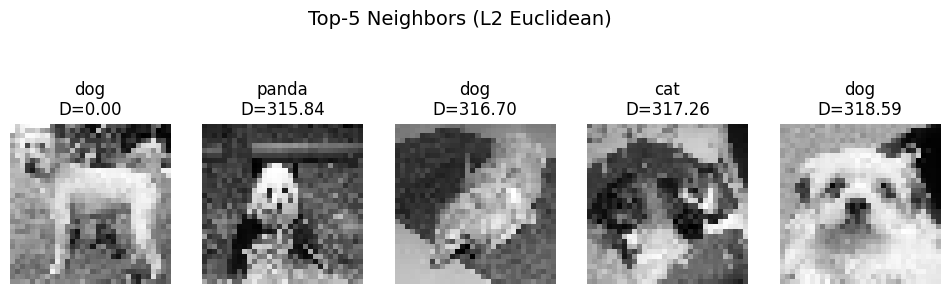

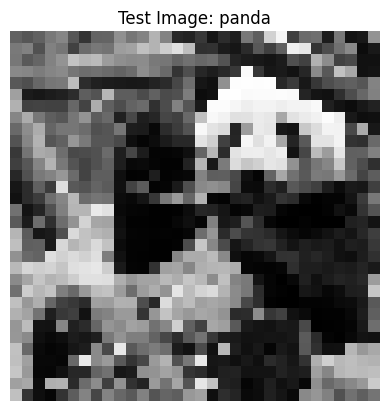

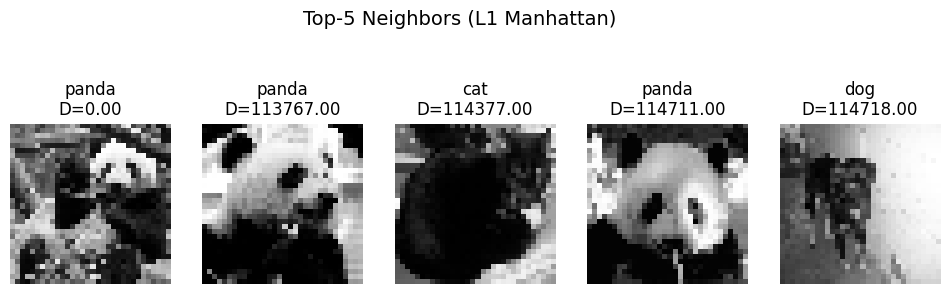

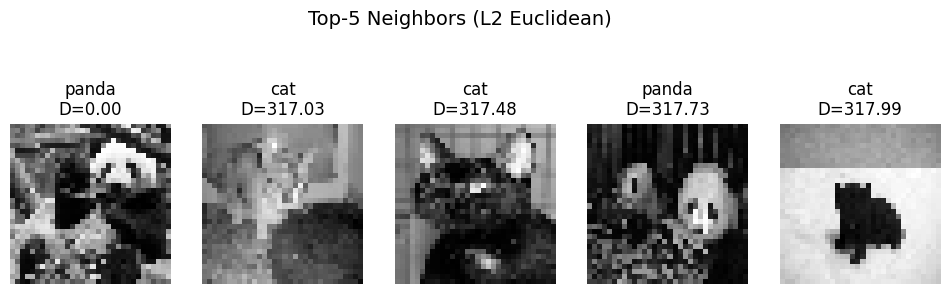

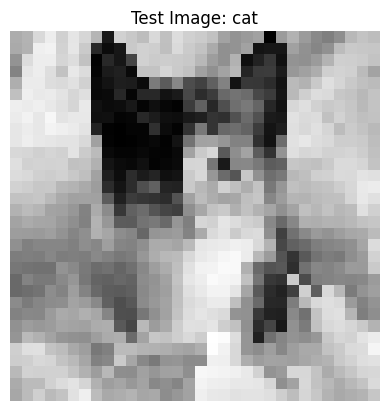

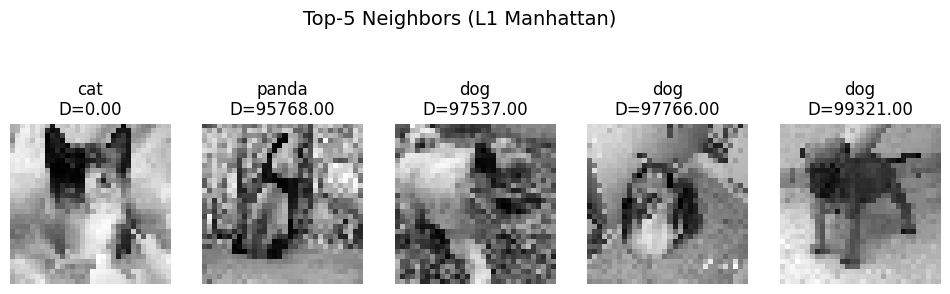

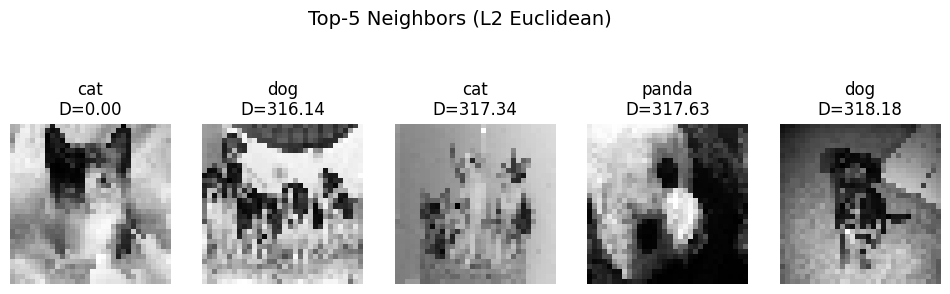

In [51]:
def top5_neighbors(train_X, train_y, test_sample, dist_type="L2"):
    distances = []
    for i in range(len(train_X)):
        d = L1(test_sample, train_X[i]) if dist_type=="L1" else L2(test_sample, train_X[i])
        distances.append((d, train_y[i], i))
    distances.sort(key=lambda x: x[0])
    return distances[:5]

def show_neighbors(results, title):
    plt.figure(figsize=(12,4))
    plt.suptitle(title, fontsize=14)
    for i, (dist, label, idx) in enumerate(results):
        img = X[idx].reshape(32,32)
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{classes[label]}\nD={dist:.2f}")
        plt.axis("off")
    plt.show()

# random test images
test_indices = random.sample(range(len(X)), 3)

for idx in test_indices:
    test_img = X[idx]
    test_label = classes[y[idx]]
    plt.imshow(test_img.reshape(32,32), cmap="gray")
    plt.title(f"Test Image: {test_label}")
    plt.axis("off")
    plt.show()
    top5_L1 = top5_neighbors(X, y, test_img, "L1")
    show_neighbors(top5_L1, "Top-5 Neighbors (L1 Manhattan)")
    top5_L2 = top5_neighbors(X, y, test_img, "L2")
    show_neighbors(top5_L2, "Top-5 Neighbors (L2 Euclidean)")


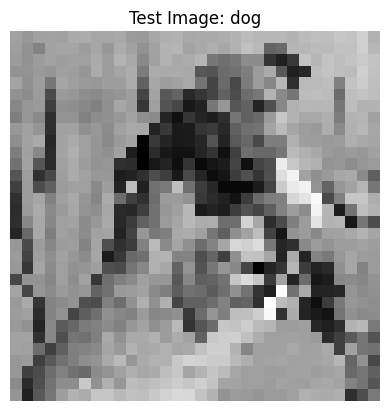

In [52]:
#random test image
import random
test_idx = random.randint(0, len(X)-1)
test_img = X[test_idx]
test_label = classes[y[test_idx]]

# Display the test image
plt.imshow(test_img.reshape(32,32), cmap='gray')
plt.title(f"Test Image: {test_label}")
plt.axis('off')
plt.show()


In [53]:
def top5_neighbors_with_distance(train_X, train_y, test_sample, dist_type="L2"):
    distances = []
    for i in range(len(train_X)):
        d = L1(test_sample, train_X[i]) if dist_type=="L1" else L2(test_sample, train_X[i])
        distances.append((d, train_y[i], i))
    distances.sort(key=lambda x: x[0])
    return distances[:5]


In [54]:
def show_prediction(test_img, neighbors, dist_type="L2"):
    plt.figure(figsize=(12,4))
    plt.suptitle(f"Top-5 Neighbors ({dist_type})", fontsize=14)

    top_labels = []
    for i, (dist, label, idx) in enumerate(neighbors):
        top_labels.append(label)
        img = X[idx].reshape(32,32)
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap="gray")
        plt.title(f"{classes[label]}\nD={dist:.2f}")
        plt.axis("off")

    # Predicted class
    predicted_label = classes[Counter(top_labels).most_common(1)[0][0]]
    plt.show()
    print(f"Predicted Class ({dist_type}): {predicted_label}")


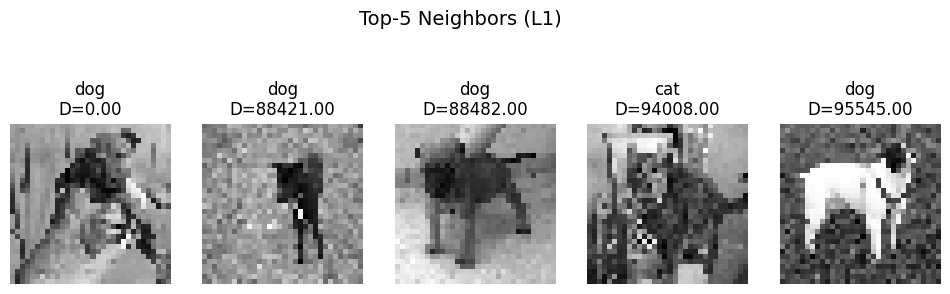

Predicted Class (L1): dog


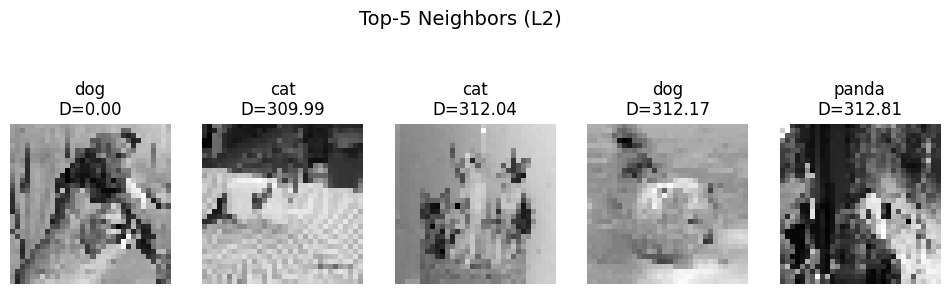

Predicted Class (L2): dog


In [55]:
# L1
top5_L1 = top5_neighbors_with_distance(X, y, test_img, "L1")
show_prediction(test_img, top5_L1, "L1")
top5_L2 = top5_neighbors_with_distance(X, y, test_img, "L2")
show_prediction(test_img, top5_L2, "L2")


# **Dicussion:**
Heere  from 5-fold cross validation the k values were 1,2,3,4,5  and we get the cross validaion result:
**L1 (Manhattan) Accuracies:** 0.427, 0.420, 0.450, 0.437, 0.430

**L2 (Euclidean) Accuracies:** 0.403, 0.410, 0.413, 0.463, 0.443
L1 distance slightly outperformed L2 for smaller K values, suggesting that Manhattan distance is better at capturing pixel-wise differences in low-resolution grayscale images.For higher K values, L2 occasionally surpassed L1, likely due to averaging effects over multiple neighbors.
Overall, the performance difference between L1 and L2 is not very large, meaning both distance metrics are applicable, but L1 may be slightly more consistent for this particular dataset.